In [1]:
using DifferentialEquations
using Plots
using LinearAlgebra
import ForwardDiff
import DiffResults
using AstrodynamicsBase
using Printf
using JSON
using CSV
using DataFrames
using ColorSchemes
using LaTeXStrings

In [44]:
include("../src/SailorMoon.jl")   # relative path to main file of module
param3b = SailorMoon.dynamics_parameters()
paramMulti = SailorMoon.multi_shoot_parameters(param3b)
gr()
fs = 16


┌ Warning: Replacing docs for `Main.SailorMoon.integrate_rk4 :: Union{Tuple{ODEProblem, Real}, Tuple{ODEProblem, Real, Union{Nothing, Vector}}, Tuple{ODEProblem, Real, Union{Nothing, Vector}, Bool}, Tuple{ODEProblem, Real, Union{Nothing, Vector}, Bool, Bool}}` in module `Main.SailorMoon`
└ @ Base.Docs docs\Docs.jl:240


16

In [45]:
function plot_circle(radius, x, y, n=100)
    circle = zeros(2,n)
    thetas = LinRange(0.0, 2π, n)
    for i = 1:n
        circle[1,i] = radius*cos(thetas[i]) + x
        circle[2,i] = radius*sin(thetas[i]) + y
    end
    return circle
end

plot_circle (generic function with 2 methods)

In [46]:
moon     = SailorMoon.plot_circle((1-param3b.mu2)*param3b.lstar, 0.0, 0.0)
earth    = SailorMoon.plot_circle(param3b.mu2*param3b.lstar, 0.0, 0.0)
earth_ub = SailorMoon.plot_circle(param3b.mu2*param3b.lstar+6375,0.0, 0.0)
earth_lb = SailorMoon.plot_circle(param3b.mu2*param3b.lstar-6375, 0.0, 0.0)
moon_soi_outer = plot_circle((1-param3b.mu2)*param3b.lstar+66000, 0.0, 0.0);

In [47]:
function interpolatecolor(cs,value, vmin, vmax)
    cs = cgrad(cs)
    color = cs[(value - vmin) / (vmax - vmin)]
    return color
end

interpolatecolor (generic function with 1 method)

In [48]:
### PARAMETERS ###################################
# csv file to load the initial solution
filename = "../run/data/diffcorr_0619_NoThrust.csv"
# dv_dir function corresponding to the csv file 
dir_func = SailorMoon.dv_no_thrust

n_arc = 5

cs = :lightrainbow 
##################################################

if dir_func == SailorMoon.dv_no_thrust
    τ_ig = 0.0
else 
    τ_ig = 1.0
end

# load initial guess
df = CSV.read(filename, DataFrame; header=0);

arcs_color = Dict(
    "xlr_bck_arc" => :blue, 
    "xlr_fwd_arc" => :red,
    "mid_bck_arc" => :green, 
    "mid_fwd_arc" => :black, 
    "lpo_arc" => :yellow
)






Dict{String, Symbol} with 5 entries:
  "lpo_arc"     => :yellow
  "xlr_bck_arc" => :blue
  "xlr_fwd_arc" => :red
  "mid_fwd_arc" => :black
  "mid_bck_arc" => :green

In [51]:

tofs= [row[1] for row in eachrow( df ) ] 
tof_max = maximum(tofs)
tof_min = minimum(tofs)

tof_max_days = tof_max * param3b.tstar / (24*60*60)
tof_min_days = tof_min * param3b.tstar / (24*60*60)

colors = [interpolatecolor(cs, row[1], tof_min, tof_max) for row in eachrow(df)]

global u = []
global t = []

# for (i, row) in enumerate( eachrow( df ) ) 
    
row = df[1,:]

    x = collect(values(row[4:end]))
    println(x)
    
#     color = colors[i]
    res, sol_param_list, sols_ballistic, tofs = SailorMoon.multishoot_trajectory2(x, dir_func, paramMulti, true, false)
        
    # ballistic legs
    for sol_ballistic in sols_ballistic

        u = sol_ballistic.u[:]
        t = sol_ballistic.t[:]
        
    end
    
    for j = 1:Int(floor(length(sol_param_list)/paramMulti.n_arc))
        
        for k = 1:paramMulti.n_arc
                        
            if mod(j,2) == 1
                # backward propagation
                sol, _, name = sol_param_list[length(sol_param_list) - j*paramMulti.n_arc + k]
                u = vcat(u, sol.u[:])
                t_append = sol.t[:] .+ t[end]
                t = vcat(t, t_append)
                
            else
                # forward propagation
                sol, _, name = sol_param_list[length(sol_param_list)-(j-1)*paramMulti.n_arc - k + 1]
                u_append = sol.u[end:-1:1, :]
                t_append = sol.t[end] .- sol.t[end:-1:1] .+ t[end]
                u = vcat(u, u_append)
                t = vcat(t, t_append)
            end

        end
        
    end
    
# end
u = Array(u)
u = hcat(u...)[:,:]

println(u)
println(t)

[389.36091764741457, -0.8206612956209202, -5.324975193310116e-24, 0.7945861687734361, -0.9589480395033531, -1.0853514365490703e-23, 1.0000000000512108, 0.5105915550195769, 4.183543066795808, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 390.22071212904024, -0.010239027316855255, 8.048849914778464e-23, -0.10454589493687384, -0.03650100030269213, 2.716714128480083e-23, 1.0000000000512108, 4.69583653293579, 6.9769147230238024, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.491696391374374e-8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.00251131061131133, -0.0004131724112137599, 1.0, 6.9769688693688305, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


[387.6985533450582 387.6985502947907 387.69855290483105 387.6985650356647 387.69859516899123 387.69864593718717 387.69872631420145 387.69884015456796 387.69899372422975 387.69919125484824 387.6994366405469 387.69973325743666 387.70008254436266 387.7004880268616 387.7009508474711 387.7014711558098 387.7020523171476 387.7026936994641 387.70339691074645 387.70416201019043 387.70499107940003 387.70588434979607 387.70684294293795 387.70786730903075 387.7089597055742 387.71012029540924 387.71135135720397 387.712654069443 387.71402968957034 387.715479030642 387.7170045251783 387.7186081509088 387.72029225252123 387.72205688685125 387.72390678551244 387.72584301453935 387.72786826199246 387.72998417273976 387.73219633690337 387.7345056589709 387.7369172687063 387.7394320316423 387.74205573298923 387.7447919249773 387.7476454855355 387.7506219750588 387.7537252137076 387.7569625300549 387.76033722276225 387.7638614123646 387.76753557042554 387.77137533339396 387.77538465054243 387.7795754098559

 388.8019063154428 388.8015629988532 388.80122550284756 388.800893704878 388.8005677184672 388.8002472125178 388.79993229329665 388.7996229127136 388.7993186314878 388.7990197656856 388.7987263000032 388.79843785326517 388.7981544080247 388.7978762972746 388.79760265649236 388.7973342410268 388.7970704479107 388.7968114766944 388.79655709761545 388.79630736970506 388.7960623954765 388.79582189777955 388.7955857081521 388.7953537230068 388.79512619953476 388.794902903908 388.79468375960334 388.7944687560971 388.79425792741273 388.79405099419137 388.7938480793169 388.7936489371256 388.7934537459073 388.7932622174914 388.79307455421184 388.7928903971385 388.79270998803685 388.79253306643875 388.79235977295144 388.7921900354205 388.792023477655 388.791860275272 388.7917005759239 388.79154406840917 388.79139082308285 388.79124059392166 388.79109366996346 388.7909498631578 388.79080899951174 388.79067109192675 388.79053613534927 388.7904041345159 388.7902750701429 388.79014872865787 388.7900

 0.3112477050972325 0.3020339523397125 0.2921740753883589 0.2817567757059725 0.27086394682184334 0.2595600530251187 0.24790657809183614 0.2359562917958614 0.2237480430252195 0.21131882269648447 0.198696547874092 0.18590438065773107 0.17296106690687074 0.15988125130532457 0.1466771066152501 0.13336217416793889 0.11993854763748463 0.10641392031930438 0.09279407994458959 0.07908148974352086 0.06528015858024015 0.051391135962755935 0.03741554883527482 0.023356624202019716 0.009211039426520485 -0.005015897749930083 -0.01932718399223141 -0.033723831979281305 -0.04820415236212527 -0.06276860396019317 -0.0774192000164545 -0.09215472964587956 -0.10697636991497911 -0.1218832238537717 -0.13687717900359128 -0.1519568289479156 -0.1671249589202385 -0.18237748876891194 -0.1977194177954118 -0.2131478625038613 -0.22866449137219133 -0.24426976783634988 -0.25996617959076407 -0.27574973504670014 -0.2916223647160656 -0.3075856149208352 -0.32363954511066867 -0.3397823984853143 -0.3560141121067333 -0.3723380

 -1.1073313921974817 -1.0973286691029382 -1.0874236500036878 -1.0776141486959128 -1.0679000033961905 -1.0582800657532239 -1.0487538799067002 -1.0393211425345936 -1.0299806933387703 -1.0207325154998377 -1.0115764459304086 -1.0025123029173804 -0.9935402620146613 -0.9846610118302537 -0.9758752114062247 -0.9671839214060619 -0.9585896456615923 -0.9500941048944402 -0.9417004799884763 -0.9334142234190123 -0.9252393027590283 -0.9171837964757095 -0.9092564157631815 -0.901467938179545 -0.8938325248314809 -0.8863680618356787 -0.8790949953572742 -0.8720393478203954 -0.8652318547328829 -0.8587066461978484 -0.8525120164879252 -0.8466850261051998 -0.8412957082625183 -0.8363672800625743 -0.8320117550979 -0.828170462971056 -0.8250673614975917 -0.8223934078695916 -0.8206612956209202 -0.8206612956209202 -0.8189480593179007 -0.8162163886368404 -0.8131128054957893 -0.8092529759125511 -0.8049158953478481 -0.8000211089273866 -0.7947130571180752 -0.789017534009865 -0.7830201155013861 -0.7767700174278341 -0.77

 -0.004434823080820616 -0.004188078915857925 -0.003942788322468723 -0.0036961494461447246 -0.0034554803245183834 -0.0032110249813138976 -0.0029719833930574877 -0.0027329066778284524 -0.0024951589901389933 -0.0022609081297988035 -0.0020278951254894756 -0.0017931032618722612 -0.001562707584575415 -0.0013309793023988175 -0.0011016967787728224 -0.0008735747230336109 -0.0006476042363010902 -0.0004230637669607959 -0.00020042841725982345 2.272411321329251e-5 0.00024230886364641466 0.00046331741849765806 0.0006796278868473166 0.0008963169414453941 0.001111488746208293 0.0013264718916374508 0.0015377981739310455 0.0017508665251328955 0.0019603070210413268 0.002170696014263172 0.0023811207592807594 0.00258816761630061 0.00279456776293935 0.0029985902694093865 0.003201225087985168 0.003402971626707538 0.003605317422339781 0.0038056848449112162 0.004004484583883049 0.004201456169399269 0.004398923089837915 0.004596095743268824 0.004791823682118117 0.0049860747581566625 0.005178367066377338 0.00537

 1.436580669488097e-22 1.4453744769318072e-22 1.4540866186789644e-22 1.462715038660809e-22 1.464270645140494e-22 1.464270645140494e-22 1.4649923679120835e-22 1.4666801405602226e-22 1.4696243906347546e-22 1.4731011127962844e-22 1.4773474426717898e-22 1.4821546340911028e-22 1.487538792140265e-22 1.4933698317840982e-22 1.4995944388628132e-22 1.50612149015177e-22 1.5128891709751702e-22 1.5198319803740536e-22 1.52689960252452e-22 1.5340461270126544e-22 1.5412346588625247e-22 1.5484342746285763e-22 1.5556193392145889e-22 1.562768748471422e-22 1.569865439922907e-22 1.5768951209904163e-22 1.583845929208067e-22 1.5907083026789064e-22 1.597473930809163e-22 1.6041359571631768e-22 1.6106885155546068e-22 1.617126445625097e-22 1.6234451404070944e-22 1.629640708505499e-22 1.6357095434616182e-22 1.6416482130443317e-22 1.647453535509312e-22 1.6531225011820057e-22 1.658652340571935e-22 1.6640401728455266e-22 1.664389782472705e-22 1.664389782472705e-22 1.664748252565748e-22 1.6657700249624433e-22 1.66757

 -5.68692274844421e-24 -5.620493636244996e-24 -5.559136778555709e-24 -5.5030978318379846e-24 -5.4536302131885514e-24 -5.4100480324644186e-24 -5.3748723527237614e-24 -5.344583934826106e-24 -5.324975193310116e-24 -5.324975193310116e-24 -5.30558889432868e-24 -5.274696517880363e-24 -5.239625430509022e-24 -5.196049433546043e-24 -5.147140072388798e-24 -5.0920117983236464e-24 -5.032314620903607e-24 -4.968360345711603e-24 -4.901130648268972e-24 -4.831195745237377e-24 -4.7592240720059594e-24 -4.68571813930635e-24 -4.611142492881481e-24 -4.535877053275049e-24 -4.460232765792025e-24 -4.384471178715965e-24 -4.308797880669863e-24 -4.233391147784023e-24 -4.185283065171967e-24 -4.185283065171967e-24 -4.166609113929873e-24 -4.139596330726175e-24 -4.108499951125208e-24 -4.070636599270159e-24 -4.028205454242188e-24 -3.980856848859855e-24 -3.929743878824315e-24 -3.875271896930568e-24 -3.81817468130543e-24 -3.758961990284374e-24 -3.698162838991552e-24 -3.636190901845603e-24 -3.57342380468531e-24 -3.510160

4.62949405782498e-25 4.591132086901542e-25 4.552269367521096e-25 4.5134789345112e-25 4.474832940526809e-25 4.435988143616812e-25 4.396881055782338e-25 4.357714575518532e-25 4.318386402842817e-25 4.279143164484784e-25 4.23887399497243e-25 4.199584922045358e-25 4.159793836808026e-25 4.1198818503775787e-25 4.0793884889985257e-25 4.0395206249168753e-25 3.99866210455446e-25 3.9583494333120597e-25 3.9176709225330803e-25 3.8768567264911306e-25 3.8362851166674486e-25 3.7955708228815253e-25 3.7541805333914933e-25 3.713203970511923e-25 3.671624425107607e-25 3.6301174537106915e-25 3.58845392201235e-25 3.5468177336665256e-25 3.5050795274986245e-25 3.4633306596826637e-25 3.4211151423915365e-25 3.379208173569843e-25 3.3366572425390456e-25 3.2946440564626085e-25 3.252188319852013e-25 3.2096591320146642e-25 3.1667929522896397e-25 3.124286012020692e-25 3.0810519561324756e-25 3.038179995896913e-25 2.994735027401671e-25 2.950897239084808e-25 2.907381315474091e-25 2.863618680611071e-25 2.819979093211316e-

 -0.09894870906726294 -0.093177465675986 -0.08746770576447917 -0.08181839664129813 -0.07623288422246625 -0.07071087307152356 -0.06525413440496994 -0.0598633603597985 -0.05454046124578096 -0.049284821478126864 -0.04409921578153971 -0.03898332959666361 -0.03796085256382562 -0.03796085256382562 -0.03739231650114733 -0.03604543289935912 -0.03415321881830801 -0.031947198554129384 -0.029305020351337557 -0.026359954118686062 -0.023103412764942387 -0.01961507768244949 -0.01592652315309794 -0.01209304977313169 -0.00814760441880575 -0.0041286415069291425 -6.479692493008647e-5 0.004020097800884855 0.008106936142067684 0.012180963148200696 0.016227854279500013 0.020237425109196842 0.02420063000045852 0.028109845590328152 0.031959475238173725 0.03574435066396221 0.03946049030906478 0.0431042963936733 0.04667307422870139 0.05016442587812631 0.05357616985564705 0.056906758389818124 0.06015447613143309 0.063318168504792 0.06639691105521968 0.06938952356501046 0.07229512847124009 0.07511312504112085 0.

 0.7862355327065665 0.7890475149774544 0.791329598666779 0.7933036586236618 0.7945861687734361 0.7945861687734361 0.7958576334928119 0.7978909826580453 0.8002102695403801 0.8031083156954619 0.8063828891383534 0.8101019387787929 0.8141633933157084 0.8185546634422364 0.8232165788867654 0.8281169346822833 0.8332154057803072 0.8384819679539124 0.8438880527436919 0.8494100048565583 0.8550281678259416 0.8607256269254014 0.8664888738318343 0.8723057982985366 0.876056411752719 0.876056411752719 0.8775207146693971 0.8796473494531055 0.8821079623162867 0.8851222987065998 0.888524444993795 0.8923515129310733 0.8965197710948718 0.9010049908671728 0.9057550506698842 0.9107349167294643 0.9159065710169949 0.9212403404726195 0.9267083465986965 0.9322883637982985 0.9379608144901076 0.9437093662380811 0.94952134321582 0.955385341068423 0.961292214366447 0.9672345029384131 0.9732062120948146 0.9792022008814116 0.9826333717413357 0.9826333717413357 0.984392272207492 0.9866262362901659 0.9893458365186139 0

 -1.1941949138308219 -1.1928077738191936 -1.1913178013209011 -1.1897238450231529 -1.188025921138042 -1.186221107708051 -1.1843100091962317 -1.1822898012419403 -1.180159541193896 -1.1779182193314006 -1.1755656093244564 -1.1730989235229403 -1.170516198711448 -1.167814967254645 -1.164996501548425 -1.1620546867723098 -1.1589893601432812 -1.1557978674783569 -1.152479292639723 -1.149026651385688 -1.145440415014785 -1.1417145951852188 -1.1378499263941562 -1.1338396912114892 -1.129680768320489 -1.1253681756518883 -1.1208960923104847 -1.1162614977069185 -1.1114563260117525 -1.1064787125255753 -1.101314030577538 -1.0959650192018797 -1.0904125738122477 -1.0846549239348766 -1.0786791627807804 -1.0724712856435068 -1.066020996122798 -1.059314121512934 -1.05233320568126 -1.0450606400451097 -1.0374860619047965 -1.0295990026969133 -1.0214023332733964 -1.012918935129046 -1.0041870088095621 -0.9952611233510635 -0.9861911524863187 -0.977019335324419 -0.967777435122212 -0.9584900226595627 -0.94917222286412

 0.1567171613902034 0.1537347474239898 0.14779128311450712 0.14196972114613998 0.1362287036819855 0.13053391904489006 0.12485979751907618 0.11919062721070495 0.1135233692638704 0.10787001032013051 0.10226036453853372 0.0967404281261317 0.09136653096137698 0.08619630504470768 0.08128683223239787 0.0766979056222222 0.07248900851803684 0.06872689613384325 0.06545971132174179 0.06274614991703263 0.06058061490044047 0.059529897696496734 0.05930177504726081 0.05930177504726081 0.058938592628961915 0.05133855989456871 0.04356224015457254 0.035670526018376274 0.027817081743672666 0.02018084308725073 0.01284992436431229 0.0058561086941596036 -0.0007736867497445293 -0.007013924843415201 -0.012806150131323782 -0.01812005989019303 -0.02285701211728465 -0.027042717685846426 -0.03049855225159019 -0.033440606765268915 -0.0354941077590529 -0.036274609452839966 -0.03650100030269213 -0.03650100030269213 -0.036727386538825804 -0.03766436600103516 -0.04011703457816261 -0.04321468511071223 -0.0469623015960

-3.1275666295313336 -3.148292925385656 -3.169146516209276 -3.1901294075469506 -3.2112273682665045 -3.2324533593120623 -3.253803221490988 -3.275277059577125 -3.2968731824633513 -3.318602066566139 -3.3404457451181675 -3.362418828349786 -3.384515711273824 -3.406740526890196 -3.4290870649019087 -3.451553091407202 -3.474142712601167 -3.4968519344648725 -3.5196758963837746 -3.542633538328296 -3.565711514524927 -3.5889088809398086 -3.6122295407359273 -3.635668264948953 -3.659226962041365 -3.6829121827311058 -3.706716799170019 -3.7306413221563033 -3.754685407611065 -3.7788443319512117 -3.803113471542386 -3.827512006400562 -3.852013262311965 -3.876635422473637 -3.9013782242324297 -3.9262342602893447 -3.951199338619997 -3.976271596137528 -4.001468431965304 -4.026764669119047 -4.052181328662004 -4.077688559160083 -4.103326339670939 -4.1290515590457275 -4.154896021234624 -4.180844773160463 -4.206899428661219 -4.233047998420549 -4.259308777911368 -4.285666227313491 -4.312113569027408 -4.33867265912

 -4.9384600464002586e-23 -4.8732113265372754e-23 -4.807563017971682e-23 -4.741612682983285e-23 -4.675429731090609e-23 -4.60908113252476e-23 -4.5426176135562797e-23 -4.4760868857411965e-23 -4.4095236205471696e-23 -4.342959756288647e-23 -4.276425822611993e-23 -4.209942393027095e-23 -4.1435354871660067e-23 -4.0772218312194326e-23 -4.011014872988243e-23 -3.944935229547754e-23 -3.878998860221494e-23 -3.8132170241943415e-23 -3.7476018116055063e-23 -3.682163649477629e-23 -3.6169154880903673e-23 -3.5518715258930006e-23 -3.4870362652177286e-23 -3.422423840986032e-23 -3.3580403512291245e-23 -3.2938983537280933e-23 -3.2300033544934405e-23 -3.166366324861061e-23 -3.1029938563832297e-23 -3.039893253133739e-23 -3.028479847011847e-23 -3.028479847011847e-23 -3.023180669328126e-23 -3.01077855146546e-23 -2.9891102782885346e-23 -2.963467830624176e-23 -2.9320658461578905e-23 -2.896402604323649e-23 -2.8563110714066184e-23 -2.8127091519282905e-23 -2.7659458953062694e-23 -2.7166573291740753e-23 -2.6652647035

 -9.688251548375432e-24 -9.733448256842061e-24 -9.77856079383905e-24 -9.823584380748476e-24 -9.86851421498865e-24 -9.913343588715401e-24 -9.958063030621683e-24 -1.0002662969126945e-23 -1.0047131523578163e-23 -1.0091449032081971e-23 -1.0135599376002886e-23 -1.0179558344563835e-23 -1.0223289043548222e-23 -1.0266761492913022e-23 -1.0309922836733701e-23 -1.035271537406959e-23 -1.0395068627439604e-23 -1.0436891722188553e-23 -1.0478070880423398e-23 -1.0518475273226741e-23 -1.0557939728459562e-23 -1.0596268751118834e-23 -1.0633243445064816e-23 -1.0668559735776532e-23 -1.070197264683305e-23 -1.0733043350678861e-23 -1.0761598810873296e-23 -1.078694841391525e-23 -1.0809394057179938e-23 -1.0827587421844874e-23 -1.0843308727977078e-23 -1.0853514365490703e-23 -1.0853514365490703e-23 -1.0863625701739713e-23 -1.0879782614104566e-23 -1.0898191458514814e-23 -1.0921163733658518e-23 -1.0947079762240745e-23 -1.097646036373353e-23 -1.1008480689739874e-23 -1.1043023662572097e-23 -1.1079606227687623e-23 -1.1

 8.793085253962871e-23 8.894663055268392e-23 8.996815774790897e-23 9.100393890811696e-23 9.203983254942437e-23 9.310848272376967e-23 9.416899797814534e-23 9.524707294567474e-23 9.633186403394712e-23 9.744238984839717e-23 9.854996667999039e-23 9.966636883530311e-23 1.0079473094530733e-22 1.0192964094066002e-22 1.0308203706613337e-22 1.0424160096690151e-22 1.0539878345144513e-22 1.065794939172685e-22 1.0776198458794914e-22 1.089782607756996e-22 1.1018601829340176e-22 1.1140936370668881e-22 1.1263520294378312e-22 1.1387722073994767e-22 1.1513649246418652e-22 1.163982498506583e-22 1.1767006693527872e-22 1.18952656215616e-22 1.202448811312383e-22 1.2153741589424693e-22 1.228534215765026e-22 1.2415820669732375e-22 1.254568217272866e-22 1.267849593673826e-22 1.2808162159664583e-22 1.2942175049683534e-22 1.3072491428915866e-22 1.3204397624039602e-22 1.3337715685961638e-22 1.347007912518133e-22 1.3603740157623755e-22 1.3736697239141782e-22 1.386868341194252e-22 1.4000846372070347e-22 1.41333692

 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.0000000000512108 1.000000000

[0.0, -0.0017272654398015593, -0.00442314537564386, -0.007208060822282914, -0.01083135880489038, -0.01474450196678579, -0.019177816066647018, -0.023957068947447185, -0.02908695751123055, -0.034507060451602345, -0.04017688800614756, -0.0460628257413692, -0.0521127480653133, -0.058325674397073896, -0.06466898594012307, -0.07110967257977197, -0.07766037011145918, -0.08428985419192628, -0.0909966364820819, -0.09776640546689645, -0.1046047524157334, -0.11150208375431853, -0.11845736809399601, -0.125465399334766, -0.13253352211641398, -0.1396551420343275, -0.14683704649873539, -0.15407886844705135, -0.16138078251798582, -0.16874079309609794, -0.17616502017693988, -0.18365660851740412, -0.1912199095710148, -0.19884899290575161, -0.2065579711929162, -0.2143445973248966, -0.22221318425626735, -0.23016369600380973, -0.23821029179861888, -0.24634920177012082, -0.2545913933537691, -0.2629326852337459, -0.2713850581110844, -0.2799523375997594, -0.2886419813833168, -0.29746271761343657, -0.306417476

-2.500138793910786, -2.4190701198759506, -2.338177754098524, -2.257238407033372, -2.176209039535557, -2.0952621229848405, -2.0148275393040036, -1.9355707139713922, -1.858309759902338, -1.7838857357886109, -1.7131352043993455, -1.6469363167389546, -1.5861644000747999, -1.53180061926819, -1.4845570774822914, -1.4452973715095612, -1.4139528781280795, -1.3987402810258798, -1.3954370909497882, -1.3954370909497882, -1.3901779857728442, -1.2800525718079419, -1.167238894806934, -1.052625610553752, -0.9384542884050064, -0.8273414265292404, -0.720586508449321, -0.6186684811379255, -0.5219936463873744, -0.430946713667008, -0.34639194852148014, -0.2687824553945193, -0.19956952356764535, -0.1383874739447275, -0.08785709527332841, -0.04482699574527382, -0.014786104607482864, -0.00336661252513637, -5.4146345027650256e-5, -5.4146345027650256e-5, -0.0033666125251363113, -0.01707714419813689, -0.05297180793657888, -0.0983172928933057, -0.1531949516657889, -0.21695392669298308, -0.2888971209915055, -0.36

 -0.9836601430614975, -0.9842382651140651, -0.9848074943917149, -0.9853674389730024, -0.9859188877953449, -0.9864613930084117, -0.9869954228278724, -0.9875209524740632, -0.9880383469133404, -0.9885474123054218, -0.9890486329467534, -0.989541793069946, -0.9900272030704481, -0.9905049510155715, -0.9909751341581257, -0.9914379680614109, -0.9918934201185654, -0.9923417785631732, -0.9927831902818866, -0.9932174670658029, -0.993644986561747, -0.9940657687854527, -0.9944799211242943, -0.9948875160773107, -0.9952888499694426, -0.9956836928817404, -0.9960724116567649, -0.9964550034223713, -0.9968316357766371, -0.9972022994698966, -0.9975670567098712, -0.9979260710825287, -0.998279374601591, -0.998626990143413, -0.9989692964366006, -0.9993061808377811, -0.9996377214033684, -0.9999640630513975, -1.0002852209815662, -1.0006013098158593, -1.0009125010045734, -1.0012187834451156, -1.0015202476947402, -1.001816972005833, -1.0021089812806079, -1.002396304918688, -1.0026792485070697, -1.002957582534231

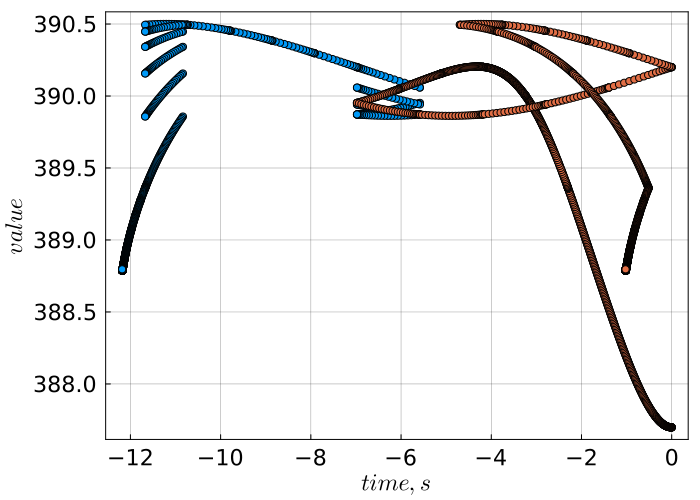

In [52]:
scatter!(p_, t[:], u[1,:])


In [42]:
sol.u

LoadError: UndefVarError: sol not defined